# Milestone 5 - SQLite and my Data - Rachel Wantuch

What changes were made to the data?
I went back to the flat csv file (player injuries) and did fare amount of changes to bring it down to the few columns I needed by the end. I didn't start off knowing I would hone in on just the 3 columns but I determined those were the most beneficial and within my scope of knowledge. I had to convert a a column I created into currency which took creating a function and then using the locale module.

The player stats (API call) didn't get touched.
The player draft (web scraping) I realized had a few issues but won't have time to thoroughly go through everything. For example some of the players that I know are under 40 years old had birthdays in the 50s and 60s. This is where domain knowledge would be helpful to really know if the data is correct. I found those anomolies when I was making graphs in Tableau. In retrospect I would make some graphs as I work to look for outliers. Another issue I didn't have time to address was players that entered the league on their own (not drafted).

Are there any legal or regulatory guidelines for your data or project topic?
If it were published on a league website I'm sure there would be some protocols needd to verify data validity since the league is a business and needs to present true, factual data.

What risks could be created based on the transformations done?
There aren't any big risks that I can think of. The biggest one I can think of is providing context for the player_injuries table. What I ended up with is cumulative games missed and cost of injuries related to payroll.

Did you make any assumptions in cleaning/transforming the data?
I made assumption in the player_stats in cleaning data that it would be better to treate players that player for multiple teams(traded mid-season) as two seperate entities for the most part. I can always apply some kind of cumulative function of some sort depending on what I was trying to show.

How was your data sourced / verified for credibility?
Personally I looked up a few players for each data source I had to see if it matched what I had. It also helped when they had their sources listed for how they got their data though.

Was your data acquired in an ethical way?
Yes. I am under the assumption that I did since it was openly out there on the internet. Publishing/Profiting off the data is where things would get questionable.

How would you mitigate any of the ethical implications you have identified?
I would have to enter into an agreement with the data owner if I decided to publish for profit I assume. 

# Creating Tables and Adding Data

In [1]:
import sqlite3
import csv
import pandas as pd
import sqlalchemy

In [2]:
#opens he database I create and created the cursor to execute commands
with sqlite3.connect("dsc540_final.db") as conn:
    c=conn.cursor()

In [3]:
# THis isn't necessary but was really helpful when I went back and did adjustments to my data repeatdely.
conn.execute("DROP TABLE player_stats")
conn.execute("DROP TABLE player_draft")
conn.execute("DROP TABLE player_injuries")

## Loading Player stats file (web scrape)

In [5]:
#Creates table with table name, Primary keys and foreign keys.
create_table="""CREATE TABLE player_stats(
                Player TEXT PRIMARY KEY,
                Age TEXT,
                Team TEXT,
                Pos TEXT,
                GP INTEGER,
                G INTEGER,
                A INTEGER,
                SR real,
                PTS INTEGER,
                PlusMinus INTEGER,
                PIM INTEGER,
                EVG INTEGER,
                PPG INTEGER,
                SHG INTEGER,
                GWG INTEGER,
                EV INTEGER,
                PP INTEGER,
                SH INTEGER,
                SOG INTEGER,
                SPCT REAL,
                TSA INTEGER,
                TOI TEXT,
                ATOI TEXT,
                FOW INTEGER,
                FOL INTEGER,
                FO_Percentage REAL,
                BLK INTEGER,
                HIT INTEGER, 
                TAKE INTEGER,
                GIVE INTEGER,
                Awards TEXT);"""

In [6]:
#Actually executes the creation of the table
conn.execute(create_table)

In [7]:
#Pulls in the data from my data sources to align with the SQL table I created
df1=pd.read_csv("player_stats.csv", index_col=False)
df1.to_sql('player_stats', conn, if_exists='replace')

1021

## Loading the Player Draft csv file (API call)

In [9]:
# This is a one to one relationship with the player stats table.
create_table='''CREATE TABLE player_draft(
                playerName TEXT PRIMARY KEY,
                birthDate datetime,
                birthPlace TEXT,
                height REAL,
                draftYear INTEGER,
                roundNumber INTEGER,
                overallPickNumber INTEGER,
                height_feet_inches TEXT,
                FOREIGN KEY (playerName) REFERENCES player_stats (Player) ON DELETE CASCADE);
                '''

In [10]:
c.execute(create_table)

In [11]:
df=pd.read_csv("player_draft.csv", index_col=False)
df.to_sql("player_draft", conn, if_exists='replace')

12704

## Loading Player injury file (csv download)

In [13]:
create_table='''CREATE TABLE player_injuries(
                PlayerName TEXT PRIMARY KEY,
                Games_Missed FLOAT,
                Chip REAL,
                FOREIGN KEY (PlayerName) REFERENCES player_stats (Player) ON DELETE CASCADE);
                '''

In [14]:
c.execute(create_table)

In [15]:
df2=pd.read_csv("player_injuries.csv", index_col=False)
df2.to_sql('player_injuries', conn, if_exists='replace')

535

# Visualizations
## Histogram of Goals for the Season

In [26]:
import matplotlib.pyplot as plt

In [27]:
#Creates a histogram for goals scored by each player by groupings of 20.
c.execute("SELECT * FROM player_stats")
data=c.fetchall()

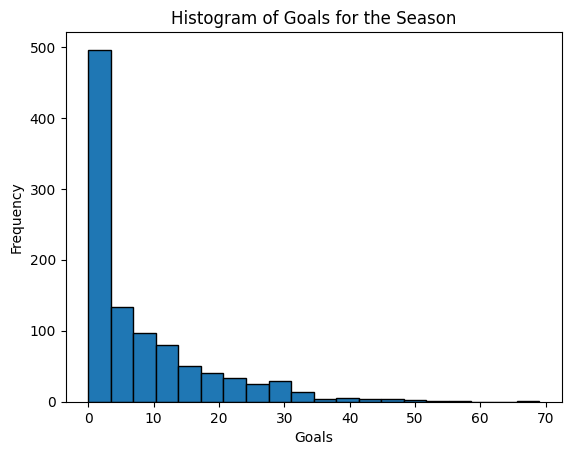

In [30]:
goals= [row[6] for row in data]
plt.hist(goals, bins=20, edgecolor='black')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.title('Histogram of Goals for the Season')
plt.show()

## Pie Chart of Teams and Shooting Rate

In [33]:
# Having trouble adding the teams to the visualization.
# Calculates the average shooting rate of each team. Goals vs games played by team average.
c.execute("SELECT avg(SR), Team FROM player_stats GROUP BY Team")
data=c.fetchall()
sr= [row[0] for row in data]
print(sr)

[0.11782398617024811, 0.04166666666666665, 0.12078604285921767, 0.12659976988209684, 0.15314547838270304, 0.12021191079347891, 0.13061912522558997, 0.14071617410093143, 0.11904510918059374, 0.09492566291322664, 0.1653736777361296, 0.15439330665513956, 0.14556371577931396, 0.14443594213132685, 0.13245649581471589, 0.15783881344654513, 0.11484678562420443, 0.11254357304476928, 0.1371892623079554, 0.13920506240499386, 0.12795525442917038, 0.11919737865068307, 0.10946004620889072, 0.10536115782802022, 0.11219619050883395, 0.09813419929130164, 0.07752544080738802, 0.10848619149612583, 0.1252708726219076, 0.14330059523275326, 0.1256884448501395, 0.14363580586614771, 0.17295364831962448, 0.09529562162683579]


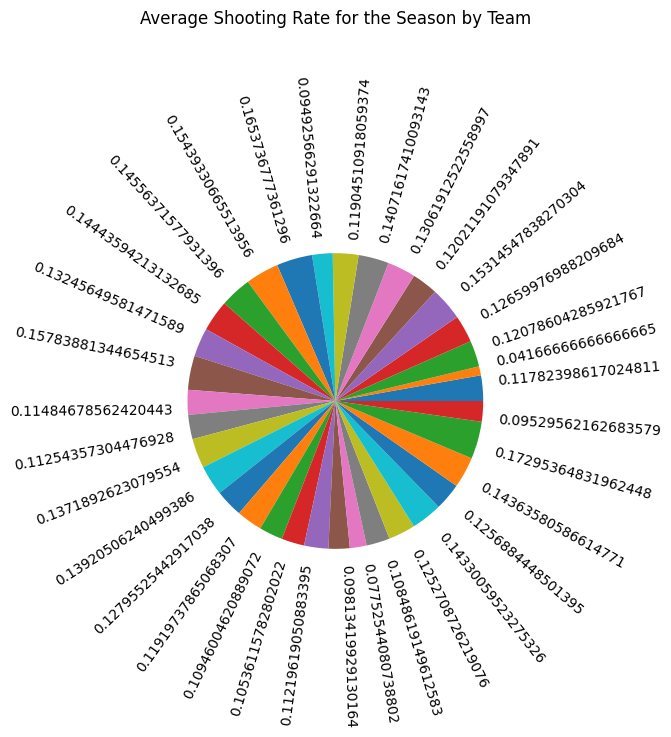

In [35]:
plt.pie(sr, labels=sr, rotatelabels=True)
plt.title('Average Shooting Rate for the Season by Team', y=1.5)
plt.show()

## Games Missed by Draft Year

In [38]:
c.execute("SELECT draftYear, Games_Missed FROM player_draft INNER JOIN player_injuries ON player_injuries.PlayerName = player_draft.playerName")
data=c.fetchall()
dy=[row[0] for row in data]
gm=[row[1] for row in data]

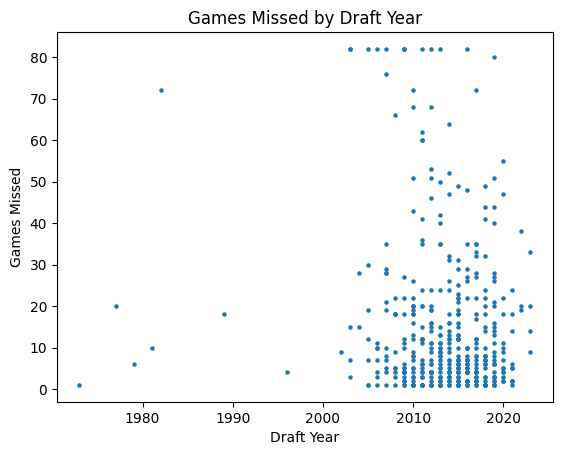

In [40]:
#In this graph I would leave it as is and not correct for jitter because the datasets only accounted for whole games missed and not partial.
plt.scatter(dy, gm, s=5)
plt.title('Games Missed by Draft Year')
plt.xlabel('Draft Year')
plt.ylabel('Games Missed')
plt.show()

## Box Plot of Games Missed

In [43]:
c.execute("SELECT Games_Missed FROM player_injuries")
data=c.fetchall()
gm=[row[0] for row in data]

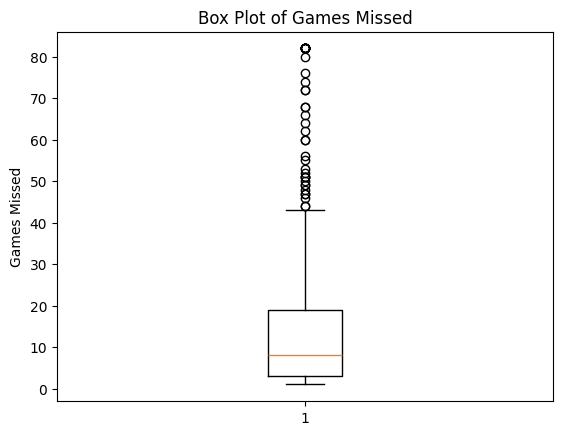

In [45]:
plt.boxplot(gm)
plt.title('Box Plot of Games Missed')
plt.ylabel('Games Missed')
plt.show()

##  Bar Plot of Age and Goals

In [48]:
c.execute("SELECT AGE, SUM(G), Age FROM player_stats GROUP BY Age")
data=c.fetchall()
goals=[row[1] for row in data]
age=[row[0] for row in data]

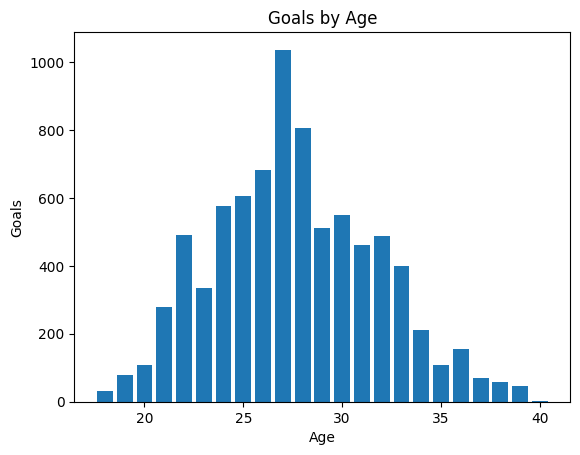

In [50]:
plt.bar(age , goals)
plt.title('Goals by Age')
plt.xlabel('Age')
plt.ylabel('Goals')
plt.show()

# Joining the 3 tables into one dataset

In [53]:
#We need to have somewhere to put the new table so I'll put it in a new variable.
c.execute("PRAGMA foreign_keys=1")
rows=c.execute("SELECT * FROM player_stats \
            LEFT JOIN player_draft ON  player_stats.Player= player_draft.playerName \
            LEFT JOIN player_injuries ON player_stats.Player = player_injuries.PlayerName")
for row in rows:
    print(row)

(0, 'Nikita Kucherov', 30, 'TBL', 'RW', 81.0, 44.0, 0.5432098765432098, 100, 144, 8, 22, 31, 13, 0, 6, 60, 40, 0, 306, 14.4, 635, '1755:10', '21:40', 2, 2, 50.0, 35, 45, 62, 96, 'ASG,ASnhl-1,Byng-22,Hart-2,Ross-1', 9720, 'Nikita Kucherov', '1993-06-17', 'Maykop, Russia', 71.0, 2011, 2, 58, '(5.0, 11.0)', 369, 'Nikita Kucherov', 1.0, '$116,000.00')
(1, 'Nathan MacKinnon', 28, 'COL', 'C', 82.0, 51.0, 0.6219512195121951, 89, 140, 35, 42, 41, 10, 0, 9, 51, 38, 0, 405, 12.6, 692, '1870:46', '22:49', 607, 707, 46.2, 69, 55, 42, 82, 'ASG,ASnhl-1,Hart-1,Selke-37,Pearson-1', 10084, 'Nathan MacKinnon', '1995-09-01', 'Halifax, NS  CAN', 72.0, 2013, 1, 1, '(6.0, 0.0)', None, None, None, None)
(2, 'Connor McDavid', 27, 'EDM', 'C', 76.0, 32.0, 0.4210526315789473, 100, 132, 35, 30, 24, 7, 1, 5, 63, 37, 0, 263, 12.2, 452, '1623:18', '21:22', 442, 423, 51.1, 39, 118, 68, 84, 'ASG,ASnhl-2,Byng-29,Hart-3,Selke-30', 10505, 'Connor McDavid', '1997-01-13', 'Richmond Hill, ON  CAN', 72.0, 2015, 1, 1, '(6.0, 

In [57]:
#This will inherently create column spots with null nan values because it is a left join. My idea was to have all players for the season and then the applicable stats for each player.
search="""SELECT * FROM player_stats \
            LEFT JOIN player_draft ON  player_stats.Player= player_draft.playerName \
            LEFT JOIN player_injuries ON player_stats.Player = player_injuries.PlayerName"""
df=pd.read_sql_query(search,conn)
df.head()
df=df.drop('index', axis=1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df

,Player,Age,Team,Pos,GP,G,SR,A,PTS,PlusMinus,PIM,EVG,PPG,SHG,GWG,EV,PP,SH,SOG,SPCT,TSA,TOI,ATOI,FOW,FOL,FO_Percentage,BLK,HIT,TAKE,GIVE,Awards,playerName,birthDate,birthPlace,height,draftYear,roundNumber,overallPickNumber,height_feet_inches,PlayerName,Games_Missed,Chip
0,Nikita Kucherov,30,TBL,RW,81.0,44.0,0.543210,100,144,8,22,31,13,0,6,60,40,0,306,14.4,635,1755:10,21:40,2,2,50.0,35,45,62,96,"ASG,ASnhl-1,Byng-22,Hart-2,Ross-1",Nikita Kucherov,1993-06-17,"Maykop, Russia",71.0,2011.0,2.0,58.0,"(5.0, 11.0)",Nikita Kucherov,1.0,"$116,000.00"
1,Nathan MacKinnon,28,COL,C,82.0,51.0,0.621951,89,140,35,42,41,10,0,9,51,38,0,405,12.6,692,1870:46,22:49,607,707,46.2,69,55,42,82,"ASG,ASnhl-1,Hart-1,Selke-37,Pearson-1",Nathan MacKinnon,1995-09-01,"Halifax, NS CAN",72.0,2013.0,1.0,1.0,"(6.0, 0.0)",None,NaN,None
2,Connor McDavid,27,EDM,C,76.0,32.0,0.421053,100,132,35,30,24,7,1,5,63,37,0,263,12.2,452,1623:18,21:22,442,423,51.1,39,118,68,84,"ASG,ASnhl-2,Byng-29,Hart-3,Selke-30",Connor McDavid,1997-01-13,"Richmond Hill, ON CAN",72.0,2015.0,1.0,1.0,"(6.0, 0.0)",Connor McDavid,5.0,"$762,000.00"
3,Artemi Panarin,32,NYR,LW,82.0,49.0,0.597561,71,120,18,24,38,11,0,5,37,33,1,303,16.2,651,1649:45,20:07,1,9,10.0,15,18,34,72,"ASnhl-1,Byng-15,Hart-5",None,None,None,NaN,NaN,NaN,NaN,None,None,NaN,None
4,David Pastrňák,27,BOS,RW,82.0,47.0,0.573171,63,110,21,47,35,12,0,5,40,23,0,382,12.3,718,1634:14,19:56,8,16,33.3,19,70,54,98,"ASG,ASnhl-2,Byng-49,Hart-8",None,None,None,NaN,NaN,NaN,NaN,None,None,NaN,None
5,Auston Matthews,26,TOR,C,81.0,69.0,0.851852,38,107,31,20,51,18,0,8,26,11,1,369,18.7,694,1698:17,20:58,705,614,53.4,93,90,85,54,"ASG,ASnhl-3,Byng-3,Hart-4,Richard-1,Selke-3",Auston Matthews,1997-09-17,"San Ramon, CA USA",74.0,2016.0,1.0,1.0,"(6.0, 2.0)",Auston Matthews,1.0,"$142,000.00"
6,Leon Draisaitl,28,EDM,C,81.0,41.0,0.506173,65,106,26,76,20,21,0,7,45,18,2,217,18.9,426,1676:20,20:42,826,625,56.9,26,58,82,92,ASG,Leon Draisaitl,1995-10-27,"Cologne, Germany",73.0,2014.0,1.0,3.0,"(6.0, 1.0)",None,NaN,None
7,Mikko Rantanen,27,COL,RW,80.0,42.0,0.525000,62,104,19,50,28,14,0,9,36,26,0,271,15.5,525,1832:27,22:54,275,236,53.8,49,53,43,43,ASnhl-4,Mikko Rantanen,1996-10-29,"Nousiainen, Finland",75.0,2015.0,1.0,10.0,"(6.0, 3.0)",Mikko Rantanen,2.0,"$226,000.00"
8,J.T. Miller,30,VAN,C,81.0,37.0,0.456790,66,103,32,58,25,10,2,9,36,30,0,194,19.1,376,1578:41,19:29,823,638,56.3,61,217,36,50,"ASG,ASnhl-7,Hart-11,Selke-15",J.T. Miller,1993-03-14,"East Palestine, OH USA",73.0,2011.0,1.0,15.0,"(6.0, 1.0)",None,NaN,None
9,William Nylander,27,TOR,C,82.0,40.0,0.487805,58,98,1,24,26,11,3,7,33,24,1,316,12.7,580,1632:55,19:55,56,63,47.1,29,32,68,45,"ASG,ASnhl-6,Byng-37",William Nylander,1996-05-01,"Calgary, AB CAN",71.0,2014.0,1.0,8.0,"(5.0, 11.0)",None,NaN,None


In [59]:
df.to_csv("Wantuch_DSC540_Project.csv", index=False)

In [61]:
conn.close()